In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FACE DETECTION

In [2]:
def bounding_box_area(bounding_box):
    return bounding_box[2] * bounding_box[3]

In [102]:
#violajones face detection using opencv
def detect_faces(image_path, scaleFactor=1.4, minNeighbors = 4, minSize = (500,500)):
    #read image
    image = cv2.imread(image_path)
    #load the pre-trained model
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    #convert the image to gray scale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #detect faces
    faces = face_cascade.detectMultiScale(
        gray_image,
        scaleFactor=scaleFactor,
        minNeighbors=minNeighbors,
        minSize=minSize,
    )

    HEIGHT = image.shape[0]
    WIDTH = image.shape[1]

    #if no bounding boxes are found, take most of the image
    if len(faces) == 0:
        bbox = np.array([0.2*WIDTH,0.1*HEIGHT,0.6*WIDTH,0.8*HEIGHT]).astype(int)
        return bbox
    
    #if more bounding boxes are found take the largest one 
    max_area_face = faces[0]
    for face in faces:
        if bounding_box_area(face) > bounding_box_area(max_area_face):
            max_area_face = face
    #return the bounding boxes
    return max_area_face


In [103]:
def compute_iou(box1, box2):
    # determine the (x, y)-coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[0] + box1[2], box2[0] + box2[2])
    y2 = min(box1[1] + box1[3], box2[1] + box2[3])

    # compute the area of intersection rectangle
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    #compute the area of both the prediction and ground-truth boxes
    box1_area = box1[2] * box1[3]
    box2_area = box2[2] * box2[3]

    # compute the union area
    union_area = box1_area + box2_area - inter_area
    #return IoU
    return inter_area / union_area if union_area > 0 else 0


In [104]:
def evaluate_model(dataset, scaleFactor, minNeighbors, minSize):
    #iou scores for each sample
    iou_scores = []
    for item in dataset["identity"].unique():
        #get all the samples for a particular identity
        df = dataset[dataset["identity"] == item]
        
        #for each sample of the same identity
        for i in range(len(df)):            
            path = "data/" + str(df.iloc[i]["idx"]) + ".jpg"
            # Ground truth (CNNs) bounding boxes
            gt_box = [df.iloc[i]["x_1"], df.iloc[i]["y_1"], df.iloc[i]["width"], df.iloc[i]["height"]] 
            
            # Detected bounding boxes with viola-jones
            detected_face = detect_faces(path, scaleFactor, minNeighbors, minSize)
            
            #compute iou
            iou = compute_iou(gt_box, detected_face)
            
                
        iou_scores.append(iou)

    avg_iou = np.mean(iou_scores) if iou_scores else 0
    return avg_iou

In [105]:
def optimize_parameters(dataset):
    best_params = {}
    best_iou = 0
    #grid search for best parameters
    for scaleFactor in [1.1,1.2,1.3,1.4,1.5,1.6]:
        for minNeighbors in range(3, 6):
            for minSize in [(10, 10), (50,50), (100,100), (500,500)]:
                avg_iou = evaluate_model(dataset, scaleFactor, minNeighbors, minSize)
                if avg_iou > best_iou:
                    best_iou = avg_iou
                    #dict of best parameters
                    best_params = {
                        "scaleFactor": scaleFactor,
                        "minNeighbors": minNeighbors,
                        "minSize": minSize,
                    }
    return best_params, best_iou

In [106]:
def test_model(dataset, best_params):
    #test the model with the optimized parameters, calc avg iou
    avg_iou = evaluate_model(
        dataset,
        best_params["scaleFactor"],
        best_params["minNeighbors"],
        best_params["minSize"],
    )
    print(f"Average IoU on test set: {avg_iou}")

In [9]:
# Load the dataset
df = pd.read_csv('CelebA-HQ-small.csv')
# Get the train split
df_train = df.loc[df["split"] == "train"]
# train the model
best_params, best_iou =  optimize_parameters(df_train)


In [13]:
print(f"Best parameters: {best_params}")
print(f"Best IoU on train set: {best_iou}")

Best parameters: {'scaleFactor': 1.4, 'minNeighbors': 4, 'minSize': (10, 10)}
Best IoU on train set: 0.7028187684638405


In [ ]:
#since the results were the same with all miSizes
best_params["minSize"] = (500,500)

In [108]:
# Get the test split
df_test = df.loc[df["split"] == "test"]
# test the model
test_model(best_params=best_params, dataset=df_test)

Average IoU on test set: 0.6898650672008694


FEATURE EXTRACTION

In [109]:
def chi2_distance_similarity(A, B):
    try:
        chi = 0.5 * np.sum([((a - b) ** 2) / (a + b + 1e-10) for (a, b) in zip(A, B)])
    except:
        print(A)
        print(B)    
    
    return chi


In [110]:
def euclidean_distance(features1,features2):
    return np.linalg.norm(features1 - features2)

LBP

In [111]:
from skimage.feature import local_binary_pattern

In [ ]:
def extract_lbp_features(image, radius=3, n_points=24, method='uniform', grid_size=(4, 4)):
    h, w = image.shape
    cell_h, cell_w = h // grid_size[0], w // grid_size[1]
    lbp_features = []

    # Compute LBP for the whole image
    lbp = local_binary_pattern(image, n_points, radius, method)

    # Loop through each grid cell
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            # Extract the cell region from the LBP image
            cell = lbp[i * cell_h:(i + 1) * cell_h, j * cell_w:(j + 1) * cell_w]

            # Compute the histogram for the cell
            lbp_hist, _ = np.histogram(cell.ravel(),
                                       bins=np.arange(0, n_points + 3),
                                       range=(0, n_points + 2))

            #normalize the histogram
            lbp_hist = lbp_hist.astype('float')
            lbp_hist /= (lbp_hist.sum() + 1e-6)

            # append to the features list
            lbp_features.extend(lbp_hist)

    return np.array(lbp_features)


In [113]:
def preprocess_image(image_path,bounding_box, target_size=(128, 128),useBoundingBox=True):

    # read the image
    image = cv2.imread(image_path)
    #convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
        
    if useBoundingBox:
        x1 =  bounding_box[0]
        y1 = bounding_box[1]
        width = bounding_box[2]
        height = bounding_box[3]
        gray_image = gray_image[x1:x1+width, y1:y1+height]
    
    #resize
    gray_image = cv2.resize(gray_image, target_size)
    
    return gray_image

In [114]:
def extract_all_feature_vectors_lbp(dataset, n_points=8, radius=1, grid_size=(4,4), useBoundingBox=True):
    feature_vectors = []
    image_ids = []
    for i in range(len(dataset)):   
        path = "data/" + str(dataset.iloc[i]["idx"]) + ".jpg"
        # Detected bounding boxes with viola-jones
        detected_face = detect_faces(path)
        image_ids.append(dataset.iloc[i]["identity"])
        image = preprocess_image(path, detected_face, useBoundingBox=useBoundingBox)
        feature_vectors.append(extract_lbp_features(image, radius=radius, n_points=n_points, grid_size=grid_size))
        
    return np.array(feature_vectors), image_ids



In [ ]:
def get_scores_mtx(image_mtx,image_ids, method="chi"):
    df = pd.DataFrame(np.zeros(len(image_mtx)),columns=["identity"])
    dict_of_new_cols  ={}
    for i in range(len(image_mtx)):
        tmp = []
        
        row_tst = image_mtx[i]
        #compare each row with each row
        for j in range(len(image_mtx)):
            row_train = image_mtx[j]
            if i == j:
                tmp.append(np.inf)
            elif method == "chi":
                tmp.append(chi2_distance_similarity(row_tst, row_train))
            elif method == "euc":
                tmp.append(euclidean_distance(row_tst, row_train))
                
            if i == 0:
                df.iloc[j] = {"identity":int(image_ids[j])}
        dict_of_new_cols[str(i)] = tmp


    df_tmp = pd.DataFrame(dict_of_new_cols)
    df = pd.concat([df,df_tmp],axis=1)

    #take min, also possible mean            
    df_grp = df.groupby("identity").min()
    df_grp = df_grp.reset_index()

    return df_grp


In [ ]:
def get_cmc(df_scores, image_ids):
    cmc = []
    for rank in range(1,len(df_scores+1)):
        prob = 0
        for i, col in enumerate(df_scores.drop("identity", axis=1).columns):
            #find the rank amout of smallest values 
            id = df_scores.nsmallest(rank, col)["identity"].values.astype(int)
            corr_id = image_ids[i]

            if corr_id in id:
                prob += 1 
        prob /= len(image_ids)
        if rank == 1:
            rank1 = prob

        if rank == 5:
            rank5 = prob
        cmc.append(prob)
    return cmc, rank1, rank5


In [80]:
#findig best params, by plotting cmc and printing r1,r5
def optimize_lbp(train_dataset, bbox = True):
    cmcs = []
    legends = []
    for (n_points, r) in zip([4,8,12,16,24], [1,1,1.5,2,3]):
            for grid_size in [(4,4), (8,8), (16,16), (24,24)]:
                feature_vecs,image_ids = extract_all_feature_vectors_lbp(train_dataset, n_points=n_points, radius=r, grid_size=grid_size, useBoundingBox=bbox)
                df = get_scores_mtx(feature_vecs, image_ids)
                cmc, rank1,rank5 = get_cmc(df, image_ids)
                print(f" rank 1= {rank1} for r={r}, n_points={n_points}, grid_size={grid_size}")
                cmcs.append(cmc)
                legends.append(f"r={r}, n_points={n_points}, grid_size={grid_size}")
    return cmcs,legends

In [119]:
def test_lbp_return_cmc(test_dataset,n_points=24, radius=3, grid_size=(8,8), bbox = True):
    feature_vecs,image_ids = extract_all_feature_vectors_lbp(test_dataset, n_points=n_points, radius=radius, grid_size=grid_size, useBoundingBox=bbox)
    df = get_scores_mtx(feature_vecs, image_ids)
    return get_cmc(df, image_ids)

In [120]:
def plot_all_cmcs(cmcs, legends):
    plt.figure(figsize=(20,15))
    plt.title("cmc of multiple parameters")
    plt.xlabel("Rank")
    plt.ylabel("Accuracy")
    for cmc, legend in zip(cmcs, legends):
        plt.plot(range(len(cmc)), cmc, label=legend)
        print("For parameters: " + legend)
        print(f"Rank 1 is: {cmc[0]} rank 5 is: {cmc[4]}")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Parameters")
        plt.tight_layout()  
    plt.show()

In [50]:
cmcs, legends = optimize_lbp(df_train)

In [ ]:
#saving since compuation really long
np.save('cmcs/cmcs_lbp_testing.npy', cmcs)

In [58]:
cmcs_lbp = np.load('cmcs/cmcs_lbp_testing.npy')

For parameters: r=1, n_points=4, grid_size=(4, 4)
Rank 1 is: 0.27157894736842103 rank 5 is: 0.4884210526315789
For parameters: r=1, n_points=4, grid_size=(8, 8)
Rank 1 is: 0.36 rank 5 is: 0.5726315789473684
For parameters: r=1, n_points=4, grid_size=(16, 16)
Rank 1 is: 0.38526315789473686 rank 5 is: 0.5957894736842105
For parameters: r=1, n_points=4, grid_size=(24, 24)
Rank 1 is: 0.40842105263157896 rank 5 is: 0.6231578947368421
For parameters: r=1, n_points=8, grid_size=(4, 4)
Rank 1 is: 0.28 rank 5 is: 0.5178947368421053
For parameters: r=1, n_points=8, grid_size=(8, 8)
Rank 1 is: 0.3705263157894737 rank 5 is: 0.5831578947368421
For parameters: r=1, n_points=8, grid_size=(16, 16)
Rank 1 is: 0.4357894736842105 rank 5 is: 0.6336842105263157
For parameters: r=1, n_points=8, grid_size=(24, 24)
Rank 1 is: 0.4652631578947368 rank 5 is: 0.6463157894736842
For parameters: r=1.5, n_points=12, grid_size=(4, 4)
Rank 1 is: 0.32421052631578945 rank 5 is: 0.5431578947368421
For parameters: r=1.5, 

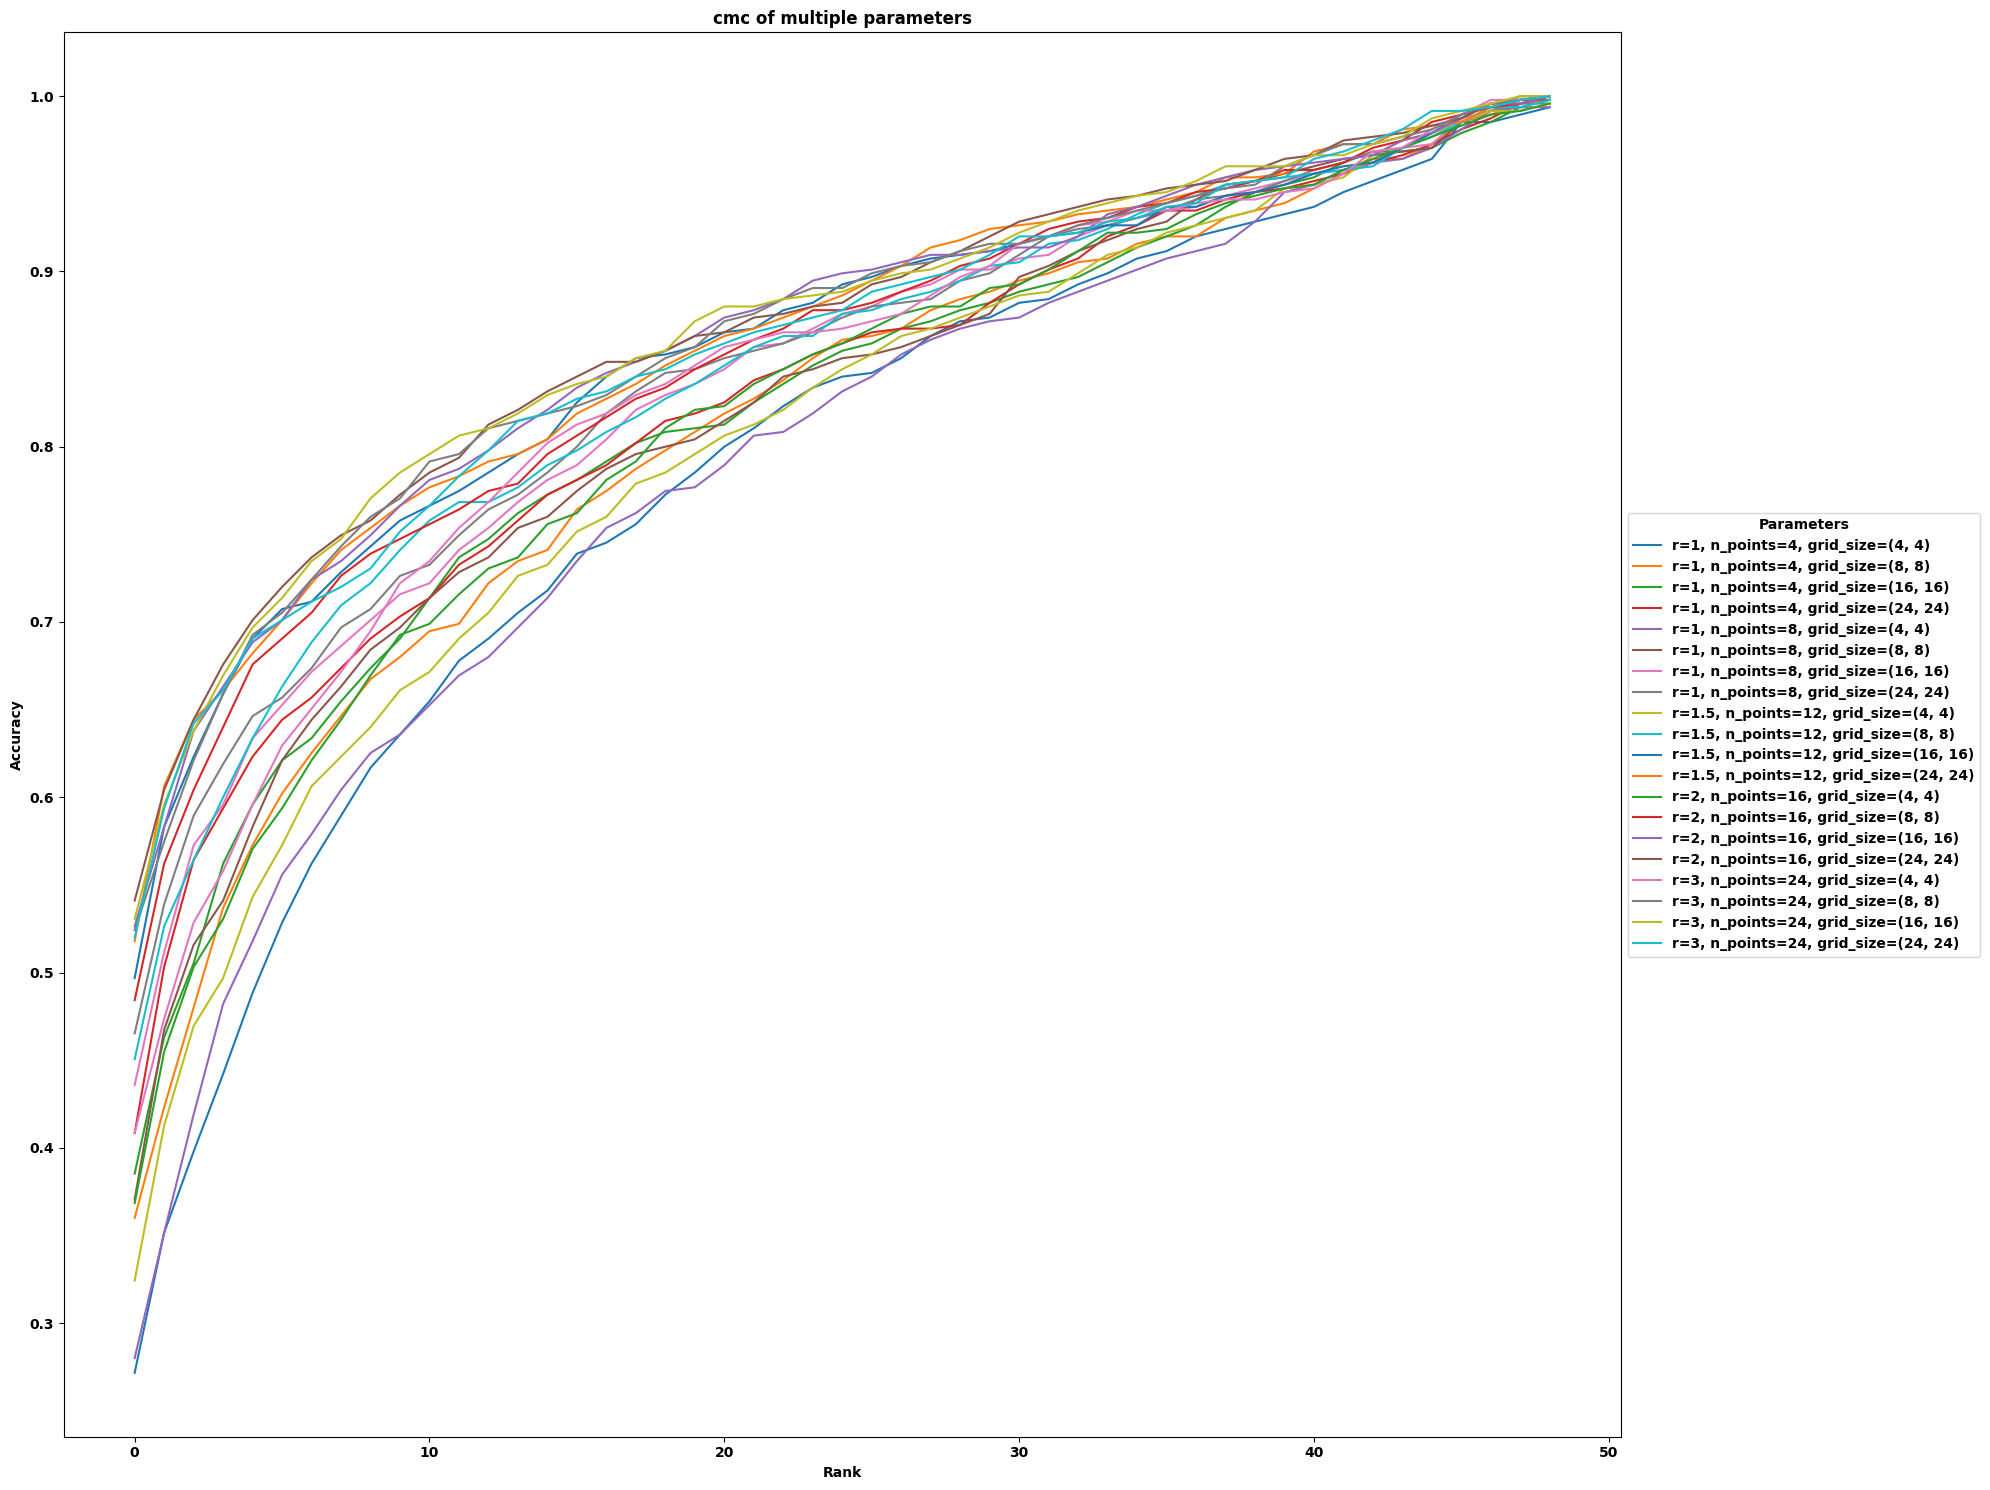

In [ ]:
#ploting all cmcs from optimizing, only did it for the first lbp optimization, takes very long, other optimizations just calculate rank1
plot_all_cmcs(cmcs_lbp, legends)

In [ ]:
cmcs_no_box,legends_no_box = optimize_lbp(df_train, bbox=False)

 rank 1= 0.24210526315789474 for r=1, n_points=4, grid_size=(4, 4)
 rank 1= 0.29473684210526313 for r=1, n_points=4, grid_size=(8, 8)
 rank 1= 0.33473684210526317 for r=1, n_points=4, grid_size=(16, 16)
 rank 1= 0.3726315789473684 for r=1, n_points=4, grid_size=(24, 24)
 rank 1= 0.24842105263157896 for r=1, n_points=8, grid_size=(4, 4)
 rank 1= 0.32210526315789473 for r=1, n_points=8, grid_size=(8, 8)
 rank 1= 0.36210526315789476 for r=1, n_points=8, grid_size=(16, 16)
 rank 1= 0.43157894736842106 for r=1, n_points=8, grid_size=(24, 24)
 rank 1= 0.25894736842105265 for r=1.5, n_points=12, grid_size=(4, 4)
 rank 1= 0.35157894736842105 for r=1.5, n_points=12, grid_size=(8, 8)
 rank 1= 0.4231578947368421 for r=1.5, n_points=12, grid_size=(16, 16)
 rank 1= 0.4842105263157895 for r=1.5, n_points=12, grid_size=(24, 24)
 rank 1= 0.28421052631578947 for r=2, n_points=16, grid_size=(4, 4)
 rank 1= 0.3642105263157895 for r=2, n_points=16, grid_size=(8, 8)
 rank 1= 0.4589473684210526 for r=2, n_p

In [98]:
np.save('cmcs/cmcs_lbp_testing_no_box.npy', cmcs_no_box)

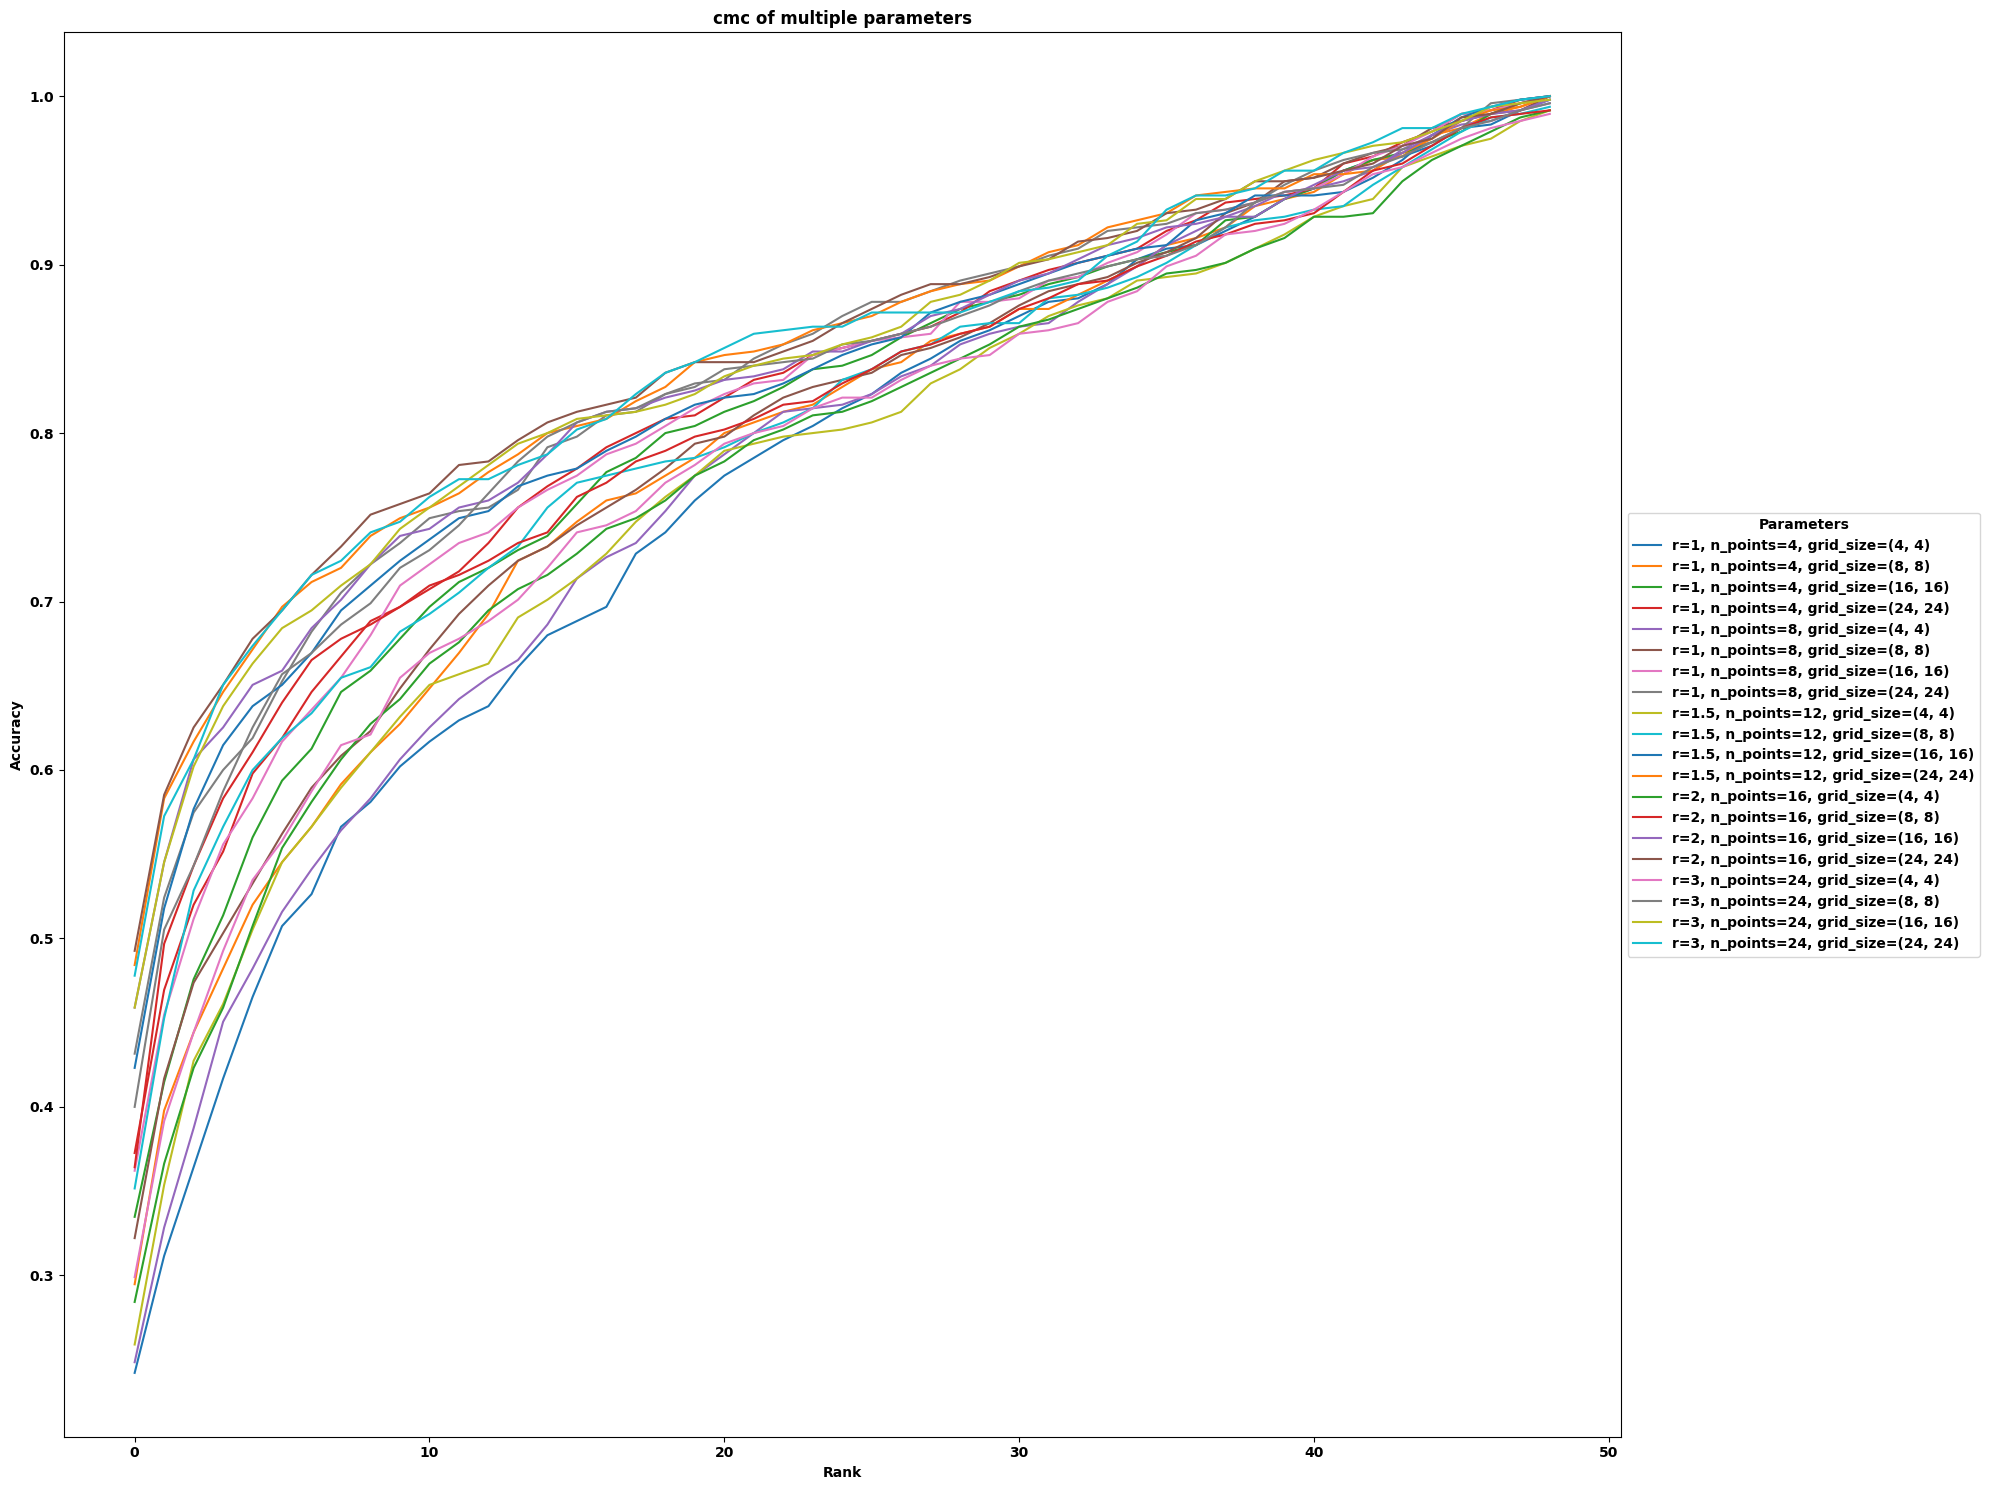

In [ ]:
#ploting all cmcs from optimizing
plot_all_cmcs(cmcs_no_box, legends_no_box)

In [ ]:
#best parameters are the same without box
r=2
n_points=16 
grid_size=(24, 24)

In [ ]:
cmc_lbp_best_no_box, r1_lbp_no_box, r2_lbp_no_box = test_lbp_return_cmc(df_test,n_points=n_points, radius=r, grid_size=grid_size, bbox=False)

Histogram of oriented gradients - HOG

In [ ]:
from skimage.feature import hog
import matplotlib.pyplot as plt

In [ ]:
def extract_all_feature_vectors_hog(dataset,orentations=8,pixels_per_cell=(16, 16),cells_per_block=(1, 1), useBoundingBox=True):
    feature_vectors = []
    image_ids = []
    for i in range(len(dataset)):   
        path = "data/" + str(dataset.iloc[i]["idx"]) + ".jpg"
        # Detected bounding boxes with viola-jones
        detected_face = detect_faces(path)
        image_ids.append(dataset.iloc[i]["identity"])
        image = preprocess_image(path, detected_face, useBoundingBox=useBoundingBox)
 
        feature_vectors.append(hog(
            image,
            orientations=orentations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block
        ))
        
    return np.array(feature_vectors), image_ids

In [ ]:
#findig best params, by plotting cmc and printing ra1,r5
def optimize_hog(train_dataset, bbox = True):
    cmcs = []
    legends = []
    for orientations in [8,9,12,16]: #[6,8,9,12,16]
        for pixels_per_cell in [(4,4), (8,8)]:#(4,4), (8,8), (16,16)
            for cells_per_block in [(3,3)]: #(2,2) (3,3)
                feature_vecs,image_ids = extract_all_feature_vectors_hog(train_dataset,orentations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block ,useBoundingBox=bbox)
                df = get_scores_mtx(feature_vecs, image_ids)
                cmc, rank1,rank5 = get_cmc(df, image_ids)
                cmcs.append(cmc)
                legends.append(f"orentations={orientations}, cells_per_block={cells_per_block}, pixels_per_cell={pixels_per_cell}")
                print(f" rank 1= {rank1} orentations={orientations}, cells_per_block={cells_per_block}, pixels_per_cell={pixels_per_cell}")
    return cmcs,legends

In [142]:
def test_hog_return_cmc(test_dataset,orientations=8,pixels_per_cell=(16, 16),cells_per_block=(1, 1), useBoundingBox=True):
    feature_vecs,image_ids = extract_all_feature_vectors_hog(test_dataset,orentations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block ,useBoundingBox=useBoundingBox)
    df = get_scores_mtx(feature_vecs, image_ids)
    return get_cmc(df, image_ids)

In [89]:
cmcs_hog, legends_hog = optimize_hog(df_train)

 rank 1= 0.5578947368421052 orentations=6, cells_per_block=(2, 2), pixels_per_cell=(4, 4)
 rank 1= 0.5852631578947368 orentations=6, cells_per_block=(3, 3), pixels_per_cell=(4, 4)
 rank 1= 0.5284210526315789 orentations=6, cells_per_block=(2, 2), pixels_per_cell=(8, 8)
 rank 1= 0.5831578947368421 orentations=6, cells_per_block=(3, 3), pixels_per_cell=(8, 8)
 rank 1= 0.5263157894736842 orentations=6, cells_per_block=(2, 2), pixels_per_cell=(16, 16)
 rank 1= 0.5536842105263158 orentations=6, cells_per_block=(3, 3), pixels_per_cell=(16, 16)
 rank 1= 0.5747368421052632 orentations=8, cells_per_block=(2, 2), pixels_per_cell=(4, 4)
 rank 1= 0.6021052631578947 orentations=8, cells_per_block=(3, 3), pixels_per_cell=(4, 4)
 rank 1= 0.5515789473684211 orentations=8, cells_per_block=(2, 2), pixels_per_cell=(8, 8)
 rank 1= 0.5978947368421053 orentations=8, cells_per_block=(3, 3), pixels_per_cell=(8, 8)
 rank 1= 0.5515789473684211 orentations=8, cells_per_block=(2, 2), pixels_per_cell=(16, 16)
 ran

In [99]:
np.save('cmcs/cmcs_hog_testing.npy', cmcs_hog)

In [100]:
cmcs_hog_tmp = np.load('cmcs/cmcs_hog_testing.npy')

For parameters: orentations=6, cells_per_block=(2, 2), pixels_per_cell=(4, 4)
Rank 1 is: 0.5578947368421052 rank 5 is: 0.72
For parameters: orentations=6, cells_per_block=(3, 3), pixels_per_cell=(4, 4)
Rank 1 is: 0.5852631578947368 rank 5 is: 0.7410526315789474
For parameters: orentations=6, cells_per_block=(2, 2), pixels_per_cell=(8, 8)
Rank 1 is: 0.5284210526315789 rank 5 is: 0.7073684210526315
For parameters: orentations=6, cells_per_block=(3, 3), pixels_per_cell=(8, 8)
Rank 1 is: 0.5831578947368421 rank 5 is: 0.7410526315789474
For parameters: orentations=6, cells_per_block=(2, 2), pixels_per_cell=(16, 16)
Rank 1 is: 0.5263157894736842 rank 5 is: 0.72
For parameters: orentations=6, cells_per_block=(3, 3), pixels_per_cell=(16, 16)
Rank 1 is: 0.5536842105263158 rank 5 is: 0.7347368421052631
For parameters: orentations=8, cells_per_block=(2, 2), pixels_per_cell=(4, 4)
Rank 1 is: 0.5747368421052632 rank 5 is: 0.7410526315789474
For parameters: orentations=8, cells_per_block=(3, 3), pix

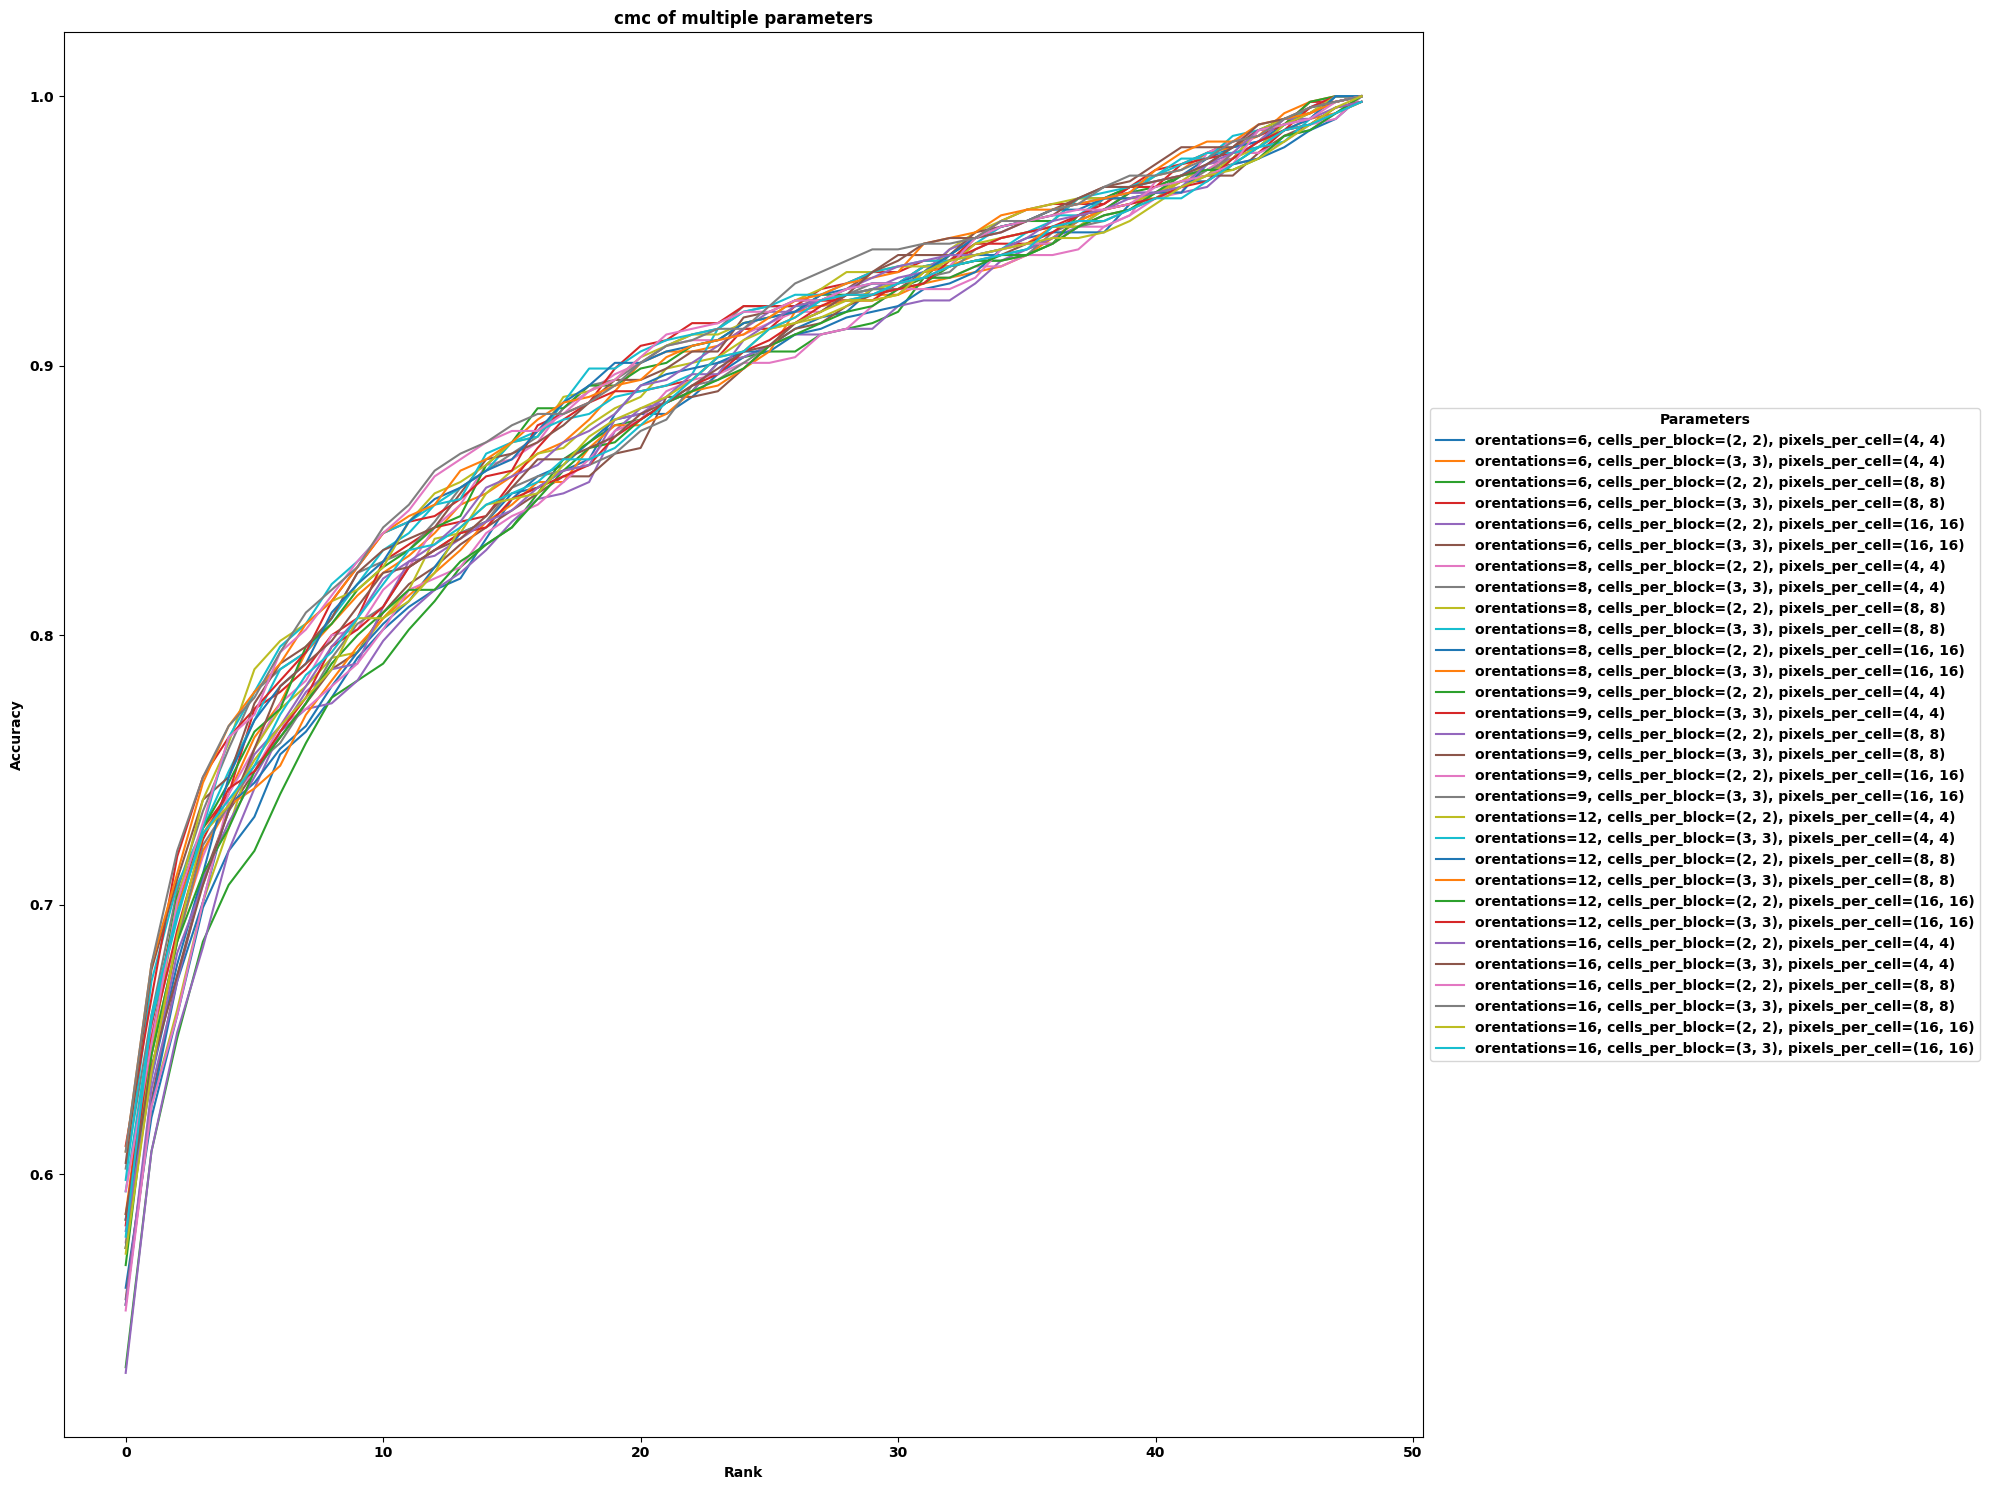

In [101]:
#ploting all cmcs from optimizing
plot_all_cmcs(cmcs_hog_tmp, legends_hog)

In [132]:
#took slightly less possible params for no bbox
cmcs_hog_no_box, legends_hog_no_box = optimize_hog(df_train, bbox=False)
np.save('cmcs/cmcs_hog_testing_no_box.npy', cmcs_hog_no_box)

 rank 1= 0.6021052631578947 orentations=8, cells_per_block=(3, 3), pixels_per_cell=(4, 4)
 rank 1= 0.5663157894736842 orentations=8, cells_per_block=(3, 3), pixels_per_cell=(8, 8)
 rank 1= 0.6147368421052631 orentations=9, cells_per_block=(3, 3), pixels_per_cell=(4, 4)
 rank 1= 0.5578947368421052 orentations=9, cells_per_block=(3, 3), pixels_per_cell=(8, 8)
 rank 1= 0.5894736842105263 orentations=12, cells_per_block=(3, 3), pixels_per_cell=(4, 4)
 rank 1= 0.5705263157894737 orentations=12, cells_per_block=(3, 3), pixels_per_cell=(8, 8)
 rank 1= 0.5873684210526315 orentations=16, cells_per_block=(3, 3), pixels_per_cell=(4, 4)
 rank 1= 0.5789473684210527 orentations=16, cells_per_block=(3, 3), pixels_per_cell=(8, 8)


For parameters: orentations=8, cells_per_block=(3, 3), pixels_per_cell=(4, 4)
Rank 1 is: 0.6021052631578947 rank 5 is: 0.791578947368421
For parameters: orentations=8, cells_per_block=(3, 3), pixels_per_cell=(8, 8)
Rank 1 is: 0.5663157894736842 rank 5 is: 0.7368421052631579
For parameters: orentations=9, cells_per_block=(3, 3), pixels_per_cell=(4, 4)
Rank 1 is: 0.6147368421052631 rank 5 is: 0.7810526315789473
For parameters: orentations=9, cells_per_block=(3, 3), pixels_per_cell=(8, 8)
Rank 1 is: 0.5578947368421052 rank 5 is: 0.7452631578947368
For parameters: orentations=12, cells_per_block=(3, 3), pixels_per_cell=(4, 4)
Rank 1 is: 0.5894736842105263 rank 5 is: 0.7852631578947369
For parameters: orentations=12, cells_per_block=(3, 3), pixels_per_cell=(8, 8)
Rank 1 is: 0.5705263157894737 rank 5 is: 0.7473684210526316
For parameters: orentations=16, cells_per_block=(3, 3), pixels_per_cell=(4, 4)
Rank 1 is: 0.5873684210526315 rank 5 is: 0.7726315789473684
For parameters: orentations=16, 

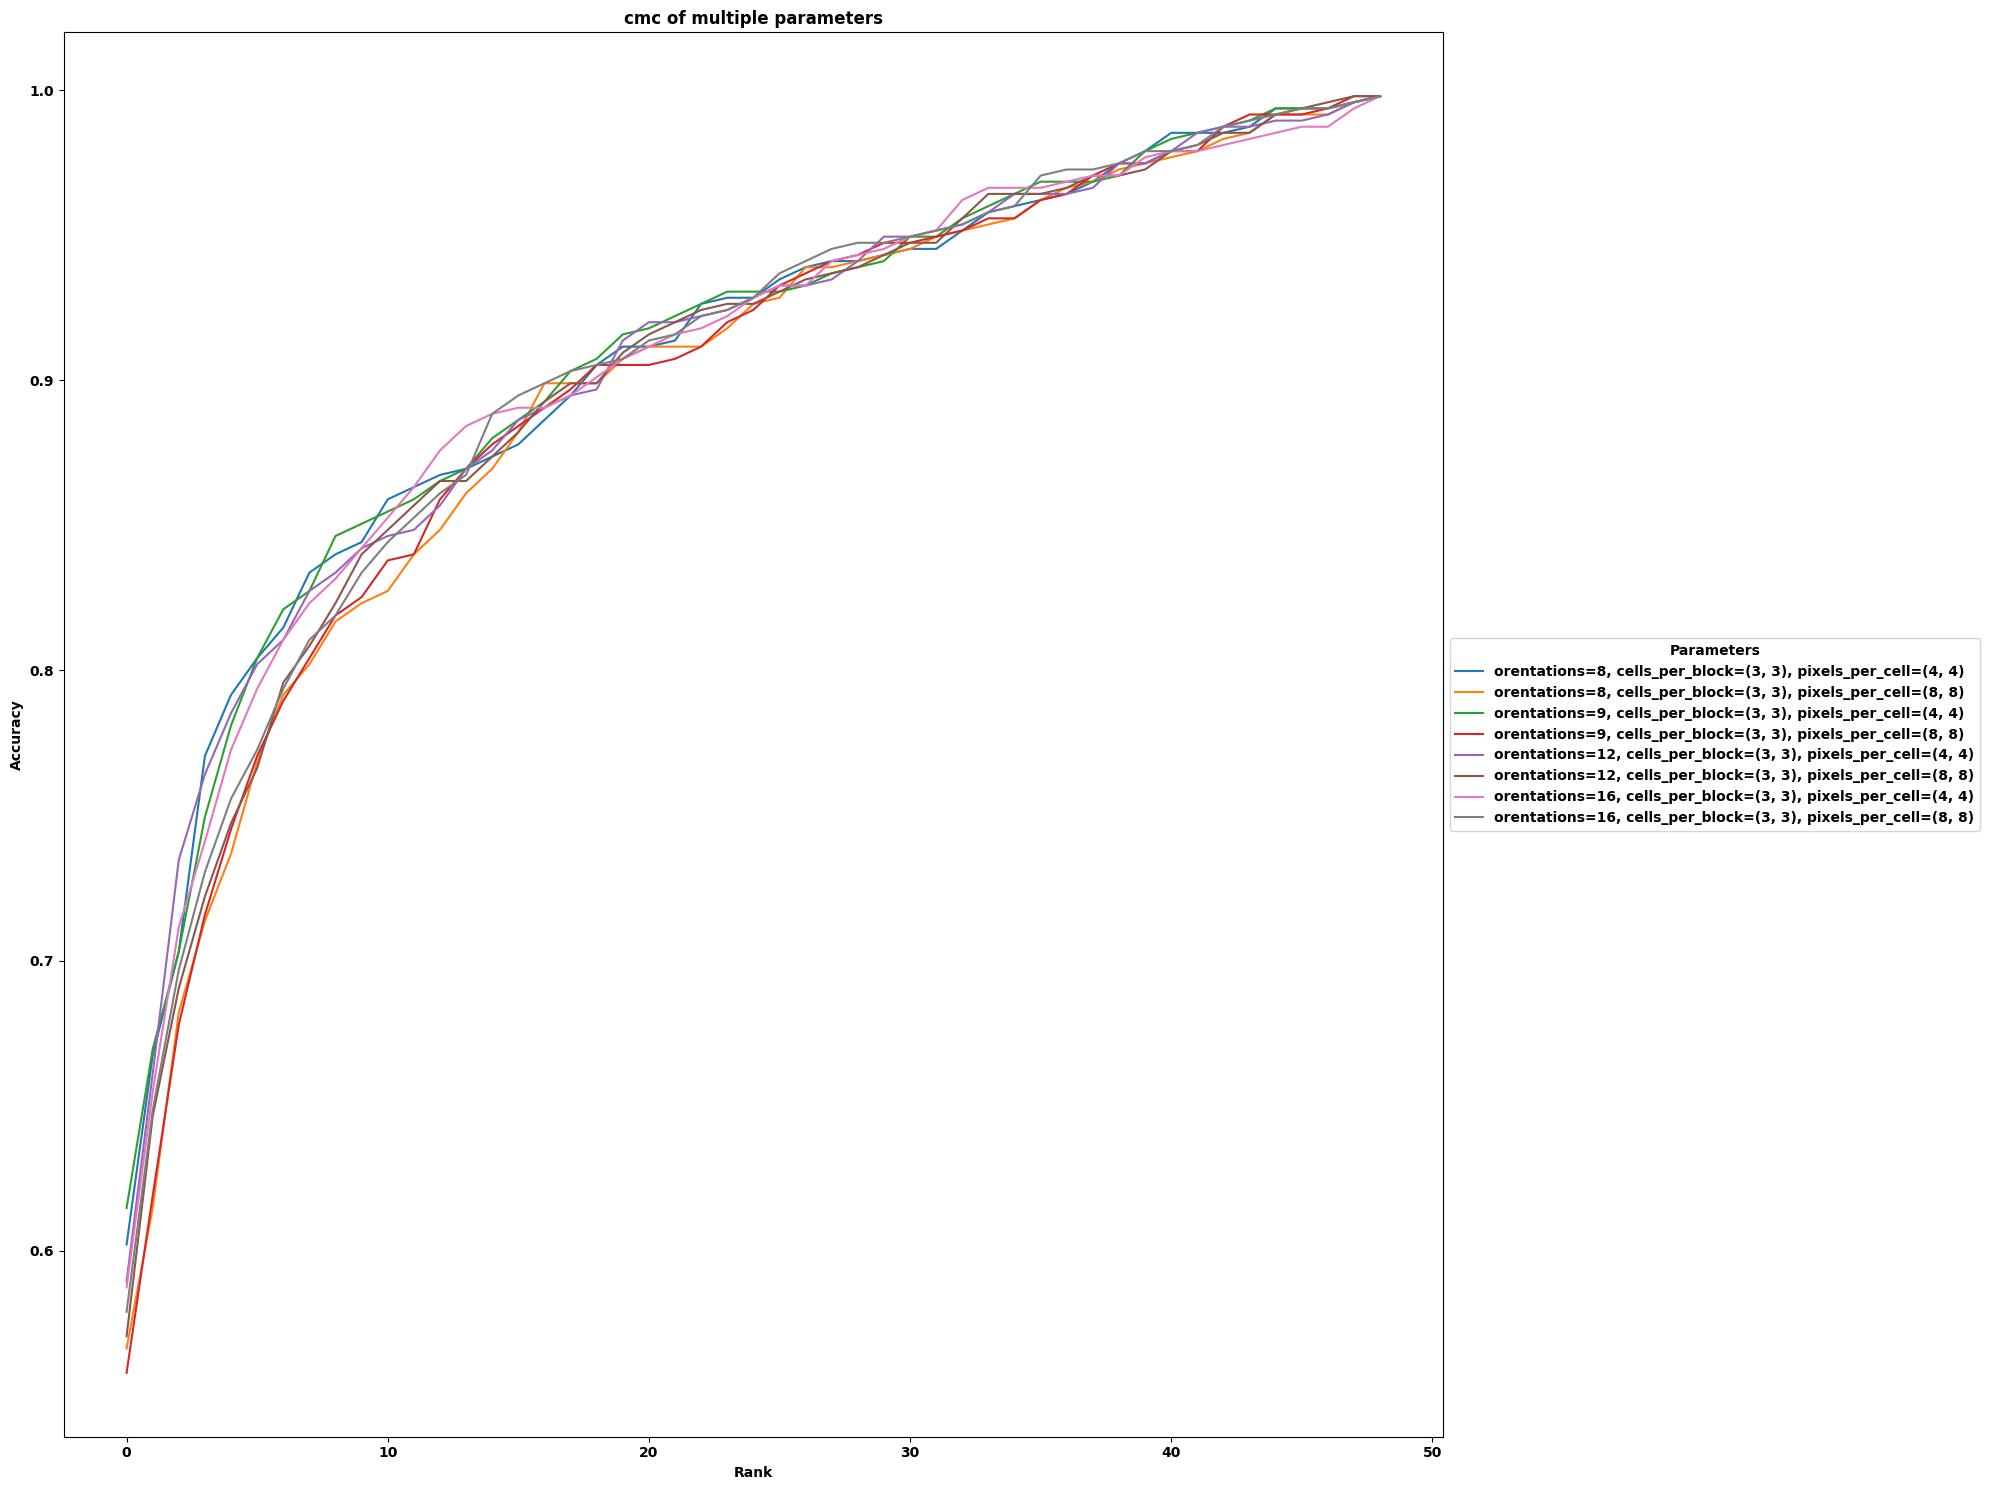

In [133]:
plot_all_cmcs(cmcs_hog_no_box,legends_hog_no_box)

DENSE SIFT

In [122]:
def extract_features_dense_sift(image, step_size = 8,window_size_overlap=2):
    window_dim = step_size*window_size_overlap

    h,w = image.shape

    sift =  cv2.SIFT_create()
    features = []
    keypoints = []
    for y in range(0, h, step_size):
        for x in range(0, w, step_size):
            kp = cv2.KeyPoint(x,y, window_dim)
            keypoints.append(kp)
   
    _,features = sift.compute(image, keypoints)
    
    return features


In [123]:
def extract_all_feature_vectors_dense_sift(dataset, step_size = 8,window_size_overlap=2,useBoundingBox=True):
    feature_vectors = []
    image_ids = []
    for i in range(len(dataset)):   
        
        path = "data/" + str(dataset.iloc[i]["idx"]) + ".jpg"
        # Detected bounding boxes with viola-jones
        detected_face = detect_faces(path)
        image_ids.append(dataset.iloc[i]["identity"])
        image = preprocess_image(path, detected_face, useBoundingBox=useBoundingBox)
        feature_vectors.append(extract_features_dense_sift(image, step_size=step_size, window_size_overlap=window_size_overlap))

    return np.array(feature_vectors), image_ids

In [124]:
def optimize_dense_sift(train_dataset, bbox = True):
    cmcs = []
    legends = []
    for step_size in [4,8,16]:
        for overlap in [1,2,3]:
            feature_vecs,image_ids = extract_all_feature_vectors_dense_sift(train_dataset,step_size=step_size, window_size_overlap=overlap, useBoundingBox=bbox)
            df = get_scores_mtx(feature_vecs, image_ids)
            cmc, rank1,rank5 = get_cmc(df, image_ids)
            cmcs.append(cmc)
            legends.append(f"step_size = {step_size}, overlap = {overlap}")
            print(f" rank 1= {rank1} step_size = {step_size}, overlap = {overlap}")
            
    return cmcs,legends

In [140]:
def test_dense_sift_return_cmc(test_dataset, step_size = 8,window_size_overlap=2,useBoundingBox=True):
    feature_vecs,image_ids = extract_all_feature_vectors_dense_sift(test_dataset,step_size=step_size, window_size_overlap=window_size_overlap, useBoundingBox=useBoundingBox)
    df = get_scores_mtx(feature_vecs, image_ids)
    return get_cmc(df, image_ids)

In [126]:
cmcs_dsift, legends_dsift = optimize_dense_sift(df_train)
np.save('cmcs/cmcs_dsift_testing.npy', cmcs_dsift)

 rank 1= 0.5621052631578948 step_size = 4, overlap = 1
 rank 1= 0.5621052631578948 step_size = 4, overlap = 2
 rank 1= 0.5473684210526316 step_size = 4, overlap = 3
 rank 1= 0.5621052631578948 step_size = 8, overlap = 1
 rank 1= 0.5368421052631579 step_size = 8, overlap = 2
 rank 1= 0.47368421052631576 step_size = 8, overlap = 3
 rank 1= 0.5284210526315789 step_size = 16, overlap = 1
 rank 1= 0.44842105263157894 step_size = 16, overlap = 2
 rank 1= 0.4126315789473684 step_size = 16, overlap = 3


For parameters: step_size = 4, overlap = 1
Rank 1 is: 0.5621052631578948 rank 5 is: 0.7305263157894737
For parameters: step_size = 4, overlap = 2
Rank 1 is: 0.5621052631578948 rank 5 is: 0.7431578947368421
For parameters: step_size = 4, overlap = 3
Rank 1 is: 0.5473684210526316 rank 5 is: 0.7178947368421053
For parameters: step_size = 8, overlap = 1
Rank 1 is: 0.5621052631578948 rank 5 is: 0.7347368421052631
For parameters: step_size = 8, overlap = 2
Rank 1 is: 0.5368421052631579 rank 5 is: 0.7178947368421053
For parameters: step_size = 8, overlap = 3
Rank 1 is: 0.47368421052631576 rank 5 is: 0.6863157894736842
For parameters: step_size = 16, overlap = 1
Rank 1 is: 0.5284210526315789 rank 5 is: 0.7136842105263158
For parameters: step_size = 16, overlap = 2
Rank 1 is: 0.44842105263157894 rank 5 is: 0.6652631578947369
For parameters: step_size = 16, overlap = 3
Rank 1 is: 0.4126315789473684 rank 5 is: 0.6147368421052631


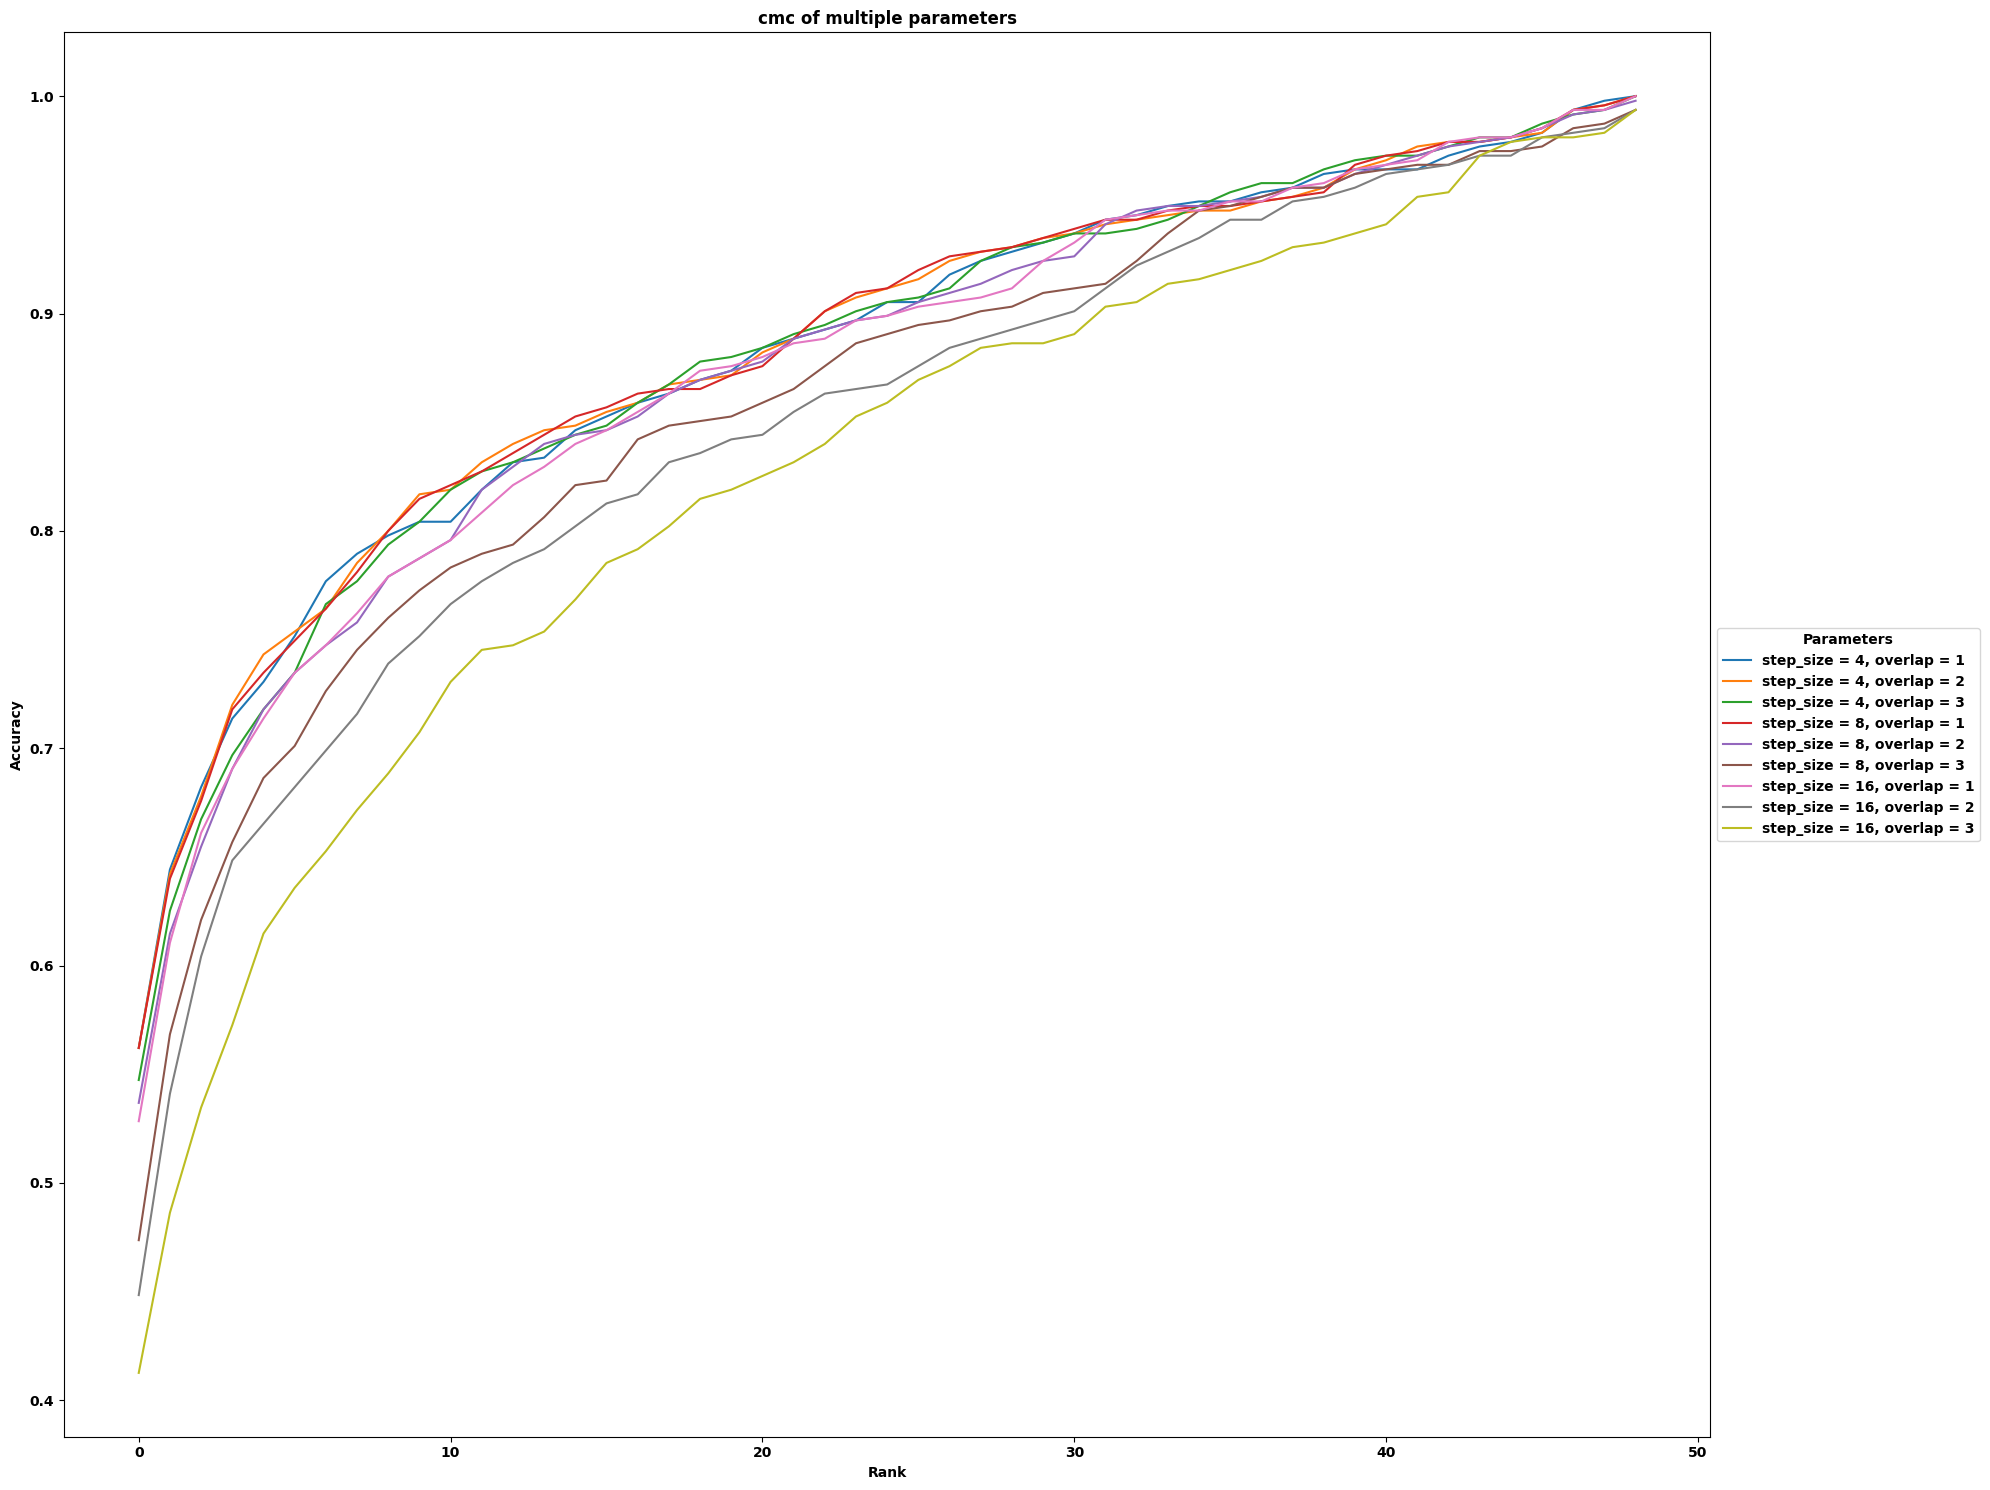

In [127]:
plot_all_cmcs(cmcs_dsift, legends_dsift)

In [129]:
cmcs_dsift_no_box, legends_dsift_no_box = optimize_dense_sift(df_train, bbox=False)
np.save('cmcs/cmcs_dsift_testing_no_box.npy', cmcs_dsift)

 rank 1= 0.5094736842105263 step_size = 4, overlap = 1
 rank 1= 0.4884210526315789 step_size = 4, overlap = 2
 rank 1= 0.47157894736842104 step_size = 4, overlap = 3
 rank 1= 0.4926315789473684 step_size = 8, overlap = 1
 rank 1= 0.44842105263157894 step_size = 8, overlap = 2
 rank 1= 0.3936842105263158 step_size = 8, overlap = 3
 rank 1= 0.4442105263157895 step_size = 16, overlap = 1
 rank 1= 0.3684210526315789 step_size = 16, overlap = 2
 rank 1= 0.32210526315789473 step_size = 16, overlap = 3


For parameters: step_size = 4, overlap = 1
Rank 1 is: 0.5094736842105263 rank 5 is: 0.7052631578947368
For parameters: step_size = 4, overlap = 2
Rank 1 is: 0.4884210526315789 rank 5 is: 0.6842105263157895
For parameters: step_size = 4, overlap = 3
Rank 1 is: 0.47157894736842104 rank 5 is: 0.6926315789473684
For parameters: step_size = 8, overlap = 1
Rank 1 is: 0.4926315789473684 rank 5 is: 0.6778947368421052
For parameters: step_size = 8, overlap = 2
Rank 1 is: 0.44842105263157894 rank 5 is: 0.6757894736842105
For parameters: step_size = 8, overlap = 3
Rank 1 is: 0.3936842105263158 rank 5 is: 0.631578947368421
For parameters: step_size = 16, overlap = 1
Rank 1 is: 0.4442105263157895 rank 5 is: 0.671578947368421
For parameters: step_size = 16, overlap = 2
Rank 1 is: 0.3684210526315789 rank 5 is: 0.5873684210526315
For parameters: step_size = 16, overlap = 3
Rank 1 is: 0.32210526315789473 rank 5 is: 0.5536842105263158


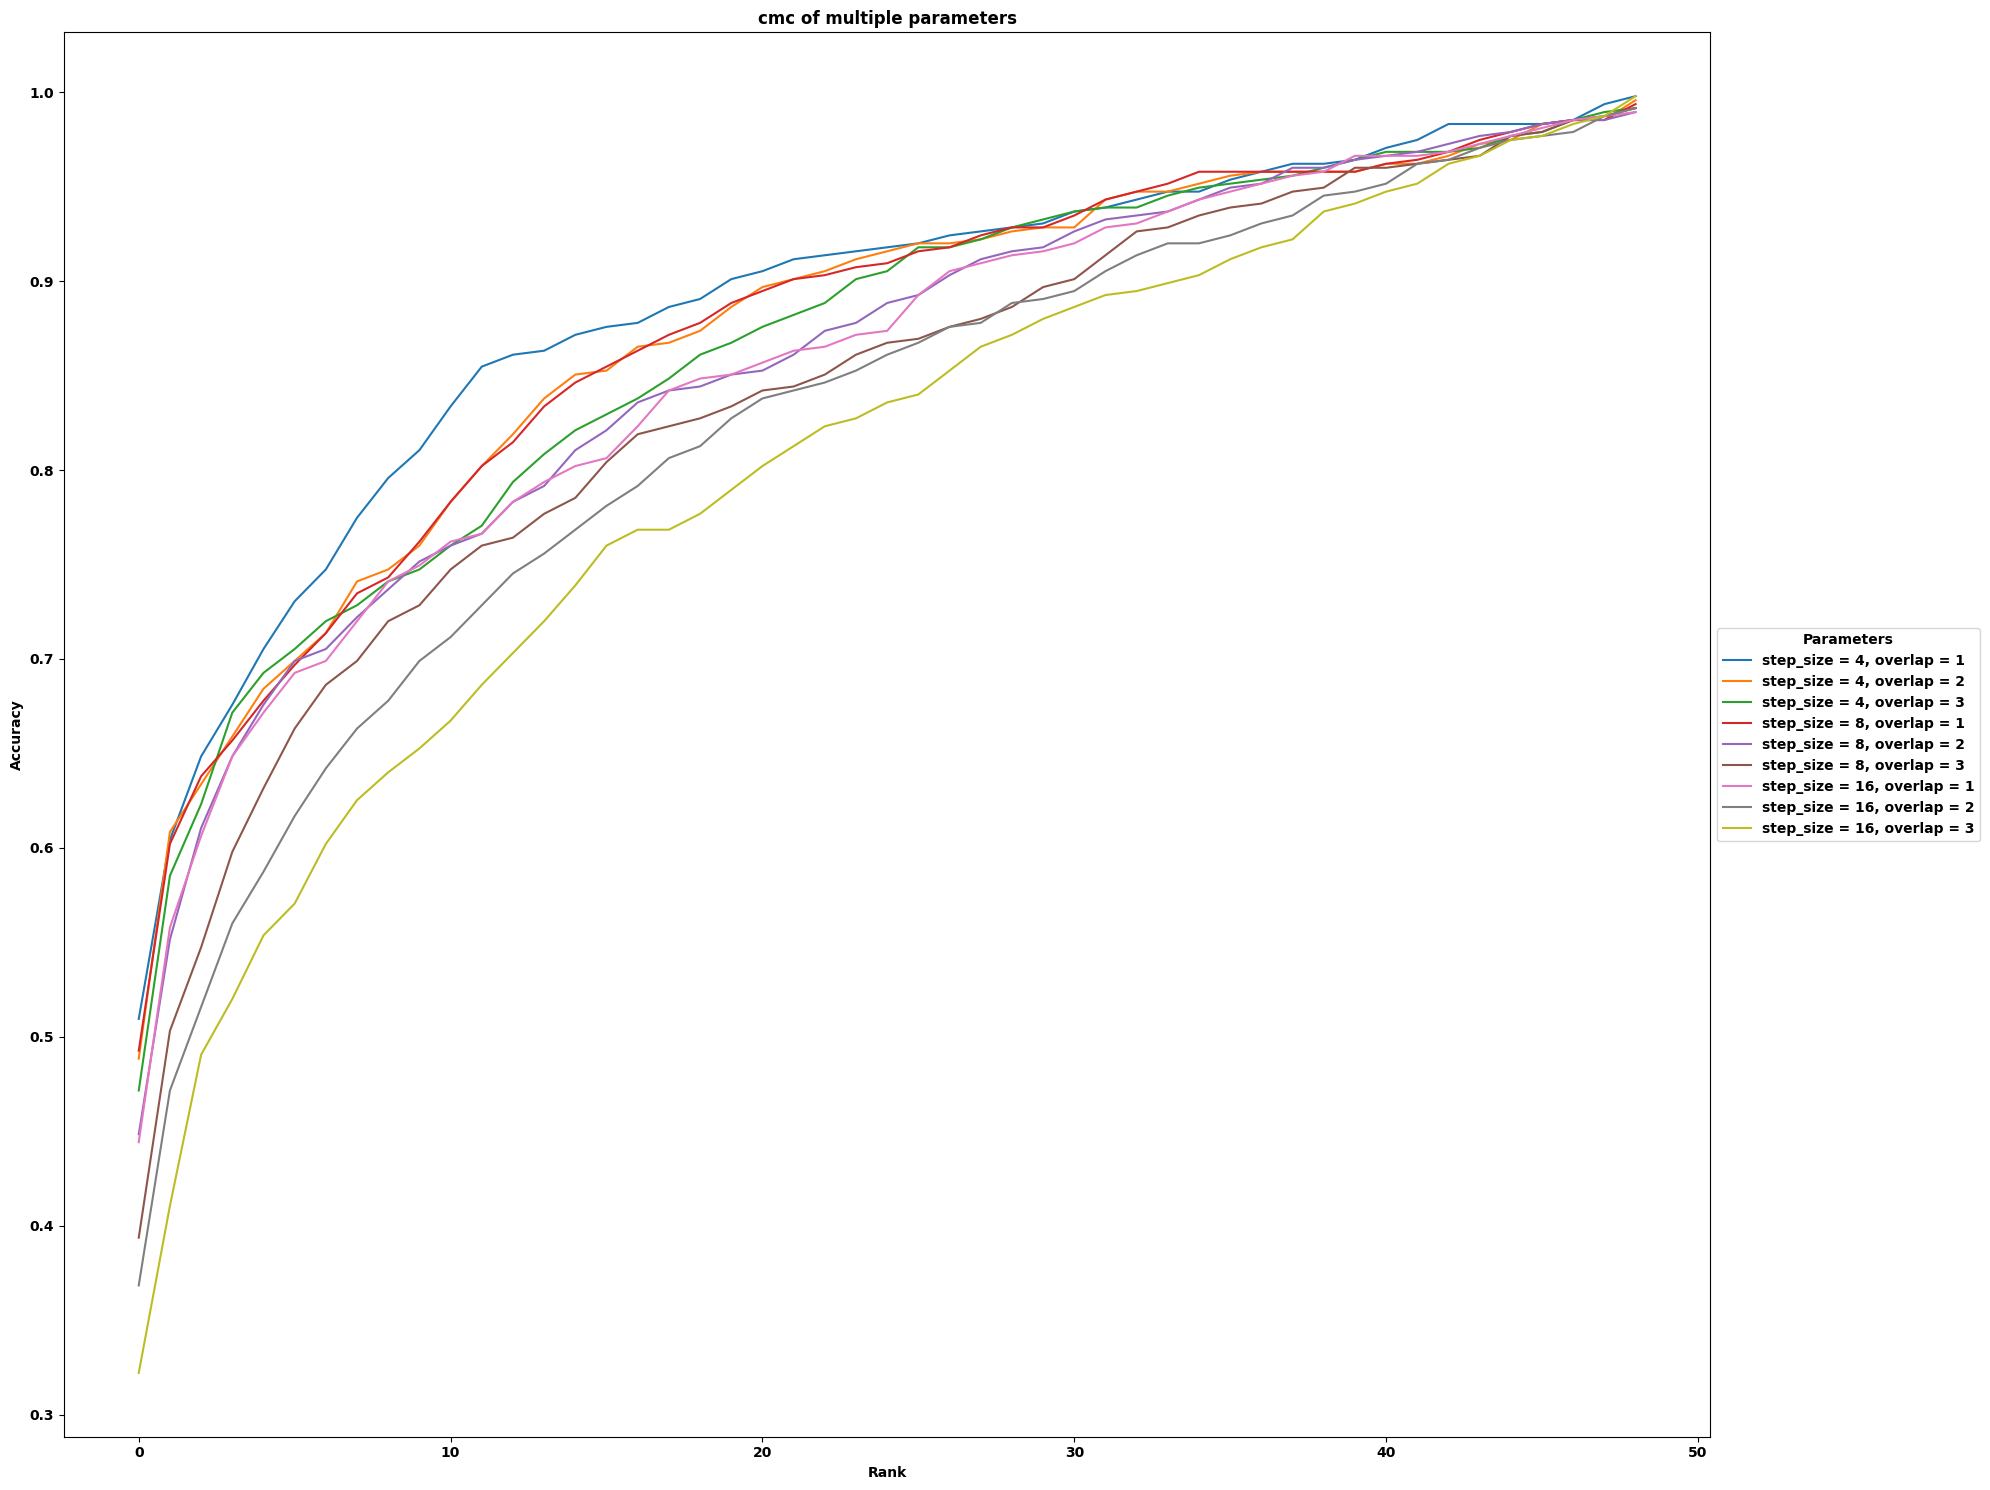

In [130]:
plot_all_cmcs(cmcs_dsift_no_box, legends_dsift_no_box)

ANALYSIS WITH BEST PARAMETERS FOUND

In [134]:
#best parameters lbp box
r=2
n_points=16 
grid_size=(24, 24)
cmc_lbp_best,r1_lbp,r5_lbp = test_lbp_return_cmc(df_test,n_points=n_points, radius=r, grid_size=grid_size)

In [143]:
#best params hog box
orentations=9
cells_per_block=(3, 3)
pixels_per_cell=(4, 4)
cmc_hog_best, r1_hog,r5_hog = test_hog_return_cmc(df_test, orientations=orentations, cells_per_block=cells_per_block, pixels_per_cell =pixels_per_cell)

In [144]:
#best params dense sift box
step_size = 4
window_size_overlap = 1
cmc_dsift_best, r1_dsift,r5_dsift = test_dense_sift_return_cmc(df_test, step_size=step_size, window_size_overlap=window_size_overlap)

In [145]:
#best parameters lbp no box
r=2
n_points=16 
grid_size=(24, 24)
cmc_lbp_best_no_box, r1_lbp_no_box, r5_lbp_no_box = test_lbp_return_cmc(df_test,n_points=n_points, radius=r, grid_size=grid_size, bbox=False)

In [146]:
#best parameters hog no box
orentations=9
cells_per_block=(3, 3)
pixels_per_cell=(4, 4)
cmc_hog__no_box, r1_hog_no_box,r5_hog_no_box = test_hog_return_cmc(df_test, orientations=orentations, cells_per_block=cells_per_block, pixels_per_cell =pixels_per_cell, useBoundingBox=False)

In [147]:
#best params dense sift no box
step_size = 4
window_size_overlap = 1
cmc_dsift_best_no_box, r1_dsift_no_box,r5_dsift_no_box = test_dense_sift_return_cmc(df_test, step_size=step_size, window_size_overlap=window_size_overlap, useBoundingBox=False)

In [148]:
np.save('cmcs/cmc_lbp_best.npy', cmc_lbp_best)
np.save('cmcs/cmc_hog_best.npy', cmc_hog_best)
np.save('cmcs/cmc_dsift_best.npy', cmc_dsift_best)
np.save('cmcs/cmc_lbp_best_no_box.npy', cmc_lbp_best_no_box)
np.save('cmcs/cmc_hog_best_no_box.npy', cmc_hog__no_box)
np.save('cmcs/cmc_dsift_best_no_box.npy', cmc_dsift_best_no_box)

In [7]:
cmc_lbp_best = np.load("cmcs/cmc_lbp_best.npy")
cmc_hog_best = np.load("cmcs/cmc_hog_best.npy")
cmc_dsift_best = np.load("cmcs/cmc_dsift_best.npy")
cmc_lbp_best_no_box = np.load("cmcs/cmc_lbp_best_no_box.npy")
cmc_hog__no_box = np.load("cmcs/cmc_hog_best_no_box.npy")
cmc_dsift_best_no_box = np.load("cmcs/cmc_dsift_best_no_box.npy")


In [149]:
print((r1_lbp, r5_lbp,r1_hog,r5_hog,r1_dsift,r5_dsift,r1_lbp_no_box, r5_lbp_no_box,r1_hog_no_box,r5_hog_no_box, r1_dsift_no_box,r5_dsift_no_box))

(0.3762135922330097, 0.6043689320388349, 0.4441747572815534, 0.662621359223301, 0.3883495145631068, 0.6286407766990292, 0.3737864077669903, 0.5946601941747572, 0.4538834951456311, 0.6456310679611651, 0.4174757281553398, 0.6213592233009708)


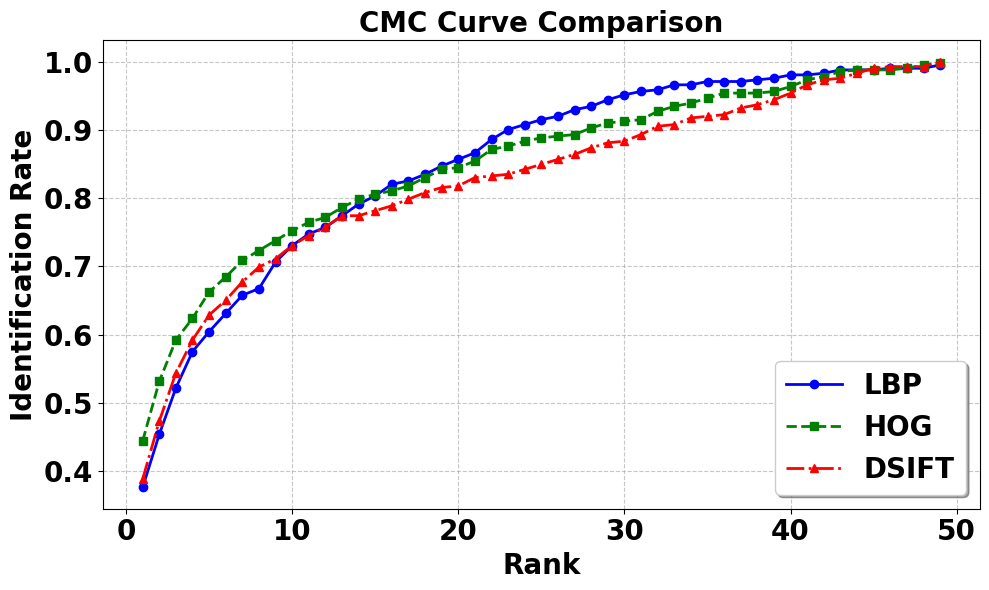

In [12]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(range(1,len(cmc_lbp_best)+1),cmc_lbp_best, label="LBP", marker='o', linestyle='-', linewidth=2, color='blue')
plt.plot(range(1,len(cmc_lbp_best)+1),cmc_hog_best, label="HOG", marker='s', linestyle='--', linewidth=2, color='green')
plt.plot(range(1,len(cmc_lbp_best)+1),cmc_dsift_best, label="DSIFT", marker='^', linestyle='-.', linewidth=2, color='red')

# Add a title and axis labels
plt.title("CMC Curve Comparison", fontsize=20)
plt.xlabel("Rank", fontsize=20)
plt.ylabel("Identification Rate", fontsize=20)

# Customize the legend
plt.legend(loc="lower right", fontsize=20, frameon=True, shadow=True, fancybox=True)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add tick parameters for better appearance
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Adjust layout
plt.tight_layout()

plt.savefig('cmcs_box.pdf')


# Show the plot
plt.show()

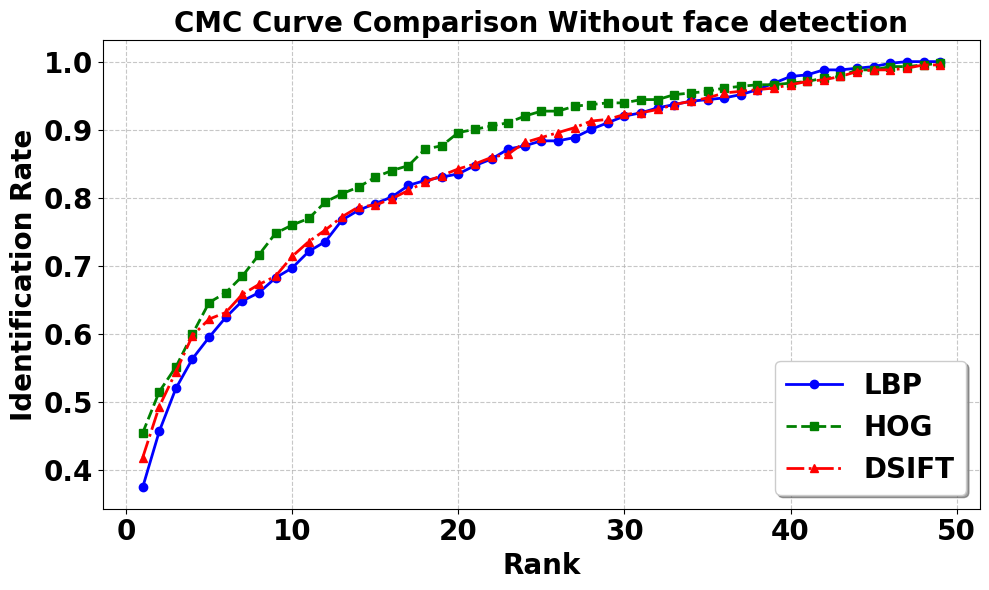

In [11]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(range(1,len(cmc_lbp_best)+1),cmc_lbp_best_no_box, label="LBP", marker='o', linestyle='-', linewidth=2, color='blue')
plt.plot(range(1,len(cmc_lbp_best)+1),cmc_hog__no_box, label="HOG", marker='s', linestyle='--', linewidth=2, color='green')
plt.plot(range(1,len(cmc_lbp_best)+1),cmc_dsift_best_no_box, label="DSIFT", marker='^', linestyle='-.', linewidth=2, color='red')

# Add a title and axis labels
plt.title("CMC Curve Comparison Without face detection", fontsize=20)
plt.xlabel("Rank", fontsize=20)
plt.ylabel("Identification Rate", fontsize=20)

# Customize the legend
plt.legend(loc="lower right", fontsize=20, frameon=True, shadow=True, fancybox=True)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add tick parameters for better appearance
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Adjust layout
plt.tight_layout()

plt.savefig('cmcs_no_box.pdf')

# Show the plot
plt.show()